In [1]:
try:
    import google.colab  # noqa: F401

    %pip install -q dataeval[torch]==v0.68.0
    !export LC_ALL="en_US.UTF-8"
    !export LD_LIBRARY_PATH="/usr/lib64-nvidia"
    !export LIBRARY_PATH="/usr/local/cuda/lib64/stubs"
    !ldconfig /usr/lib64-nvidia
except Exception:
    pass

%pip install -q tabulate

import os

from pytest import approx

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

/dataeval/.venv/bin/python3: No module named pip


Note: you may need to restart the kernel to use updated packages.


In [2]:
import random
from typing import Dict, Sequence, cast

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchmetrics
import torchvision.datasets as datasets
import torchvision.transforms.v2 as v2
from torch.utils.data import DataLoader, Dataset, Subset

from dataeval.workflows import Sufficiency

np.random.seed(0)
np.set_printoptions(formatter={"float": lambda x: f"{x:0.4f}"})
torch.manual_seed(0)
torch.set_float32_matmul_precision("high")
device = "cuda" if torch.cuda.is_available() else "cpu"
torch._dynamo.config.suppress_errors = True

random.seed(0)
torch.use_deterministic_algorithms(True)
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

In [3]:
# Download the mnist dataset and preview the images
to_tensor = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
train_ds = datasets.MNIST("./data", train=True, download=True, transform=to_tensor)
test_ds = datasets.MNIST("./data", train=False, download=True, transform=to_tensor)

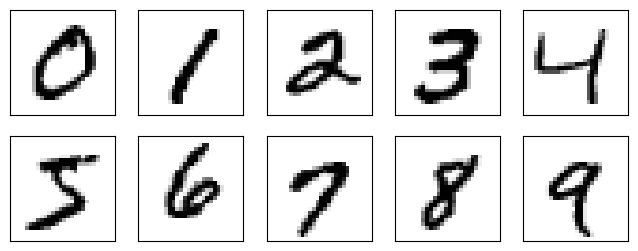

In [4]:
fig = plt.figure(figsize=(8, 3))

for lbl in range(10):
    i = (train_ds.targets == lbl).nonzero()[0][0]
    img = train_ds.data[i]
    ax = fig.add_subplot(2, 5, lbl + 1)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.imshow(img, cmap="gray_r")

In [5]:
# Take a subset of 2000 training images and 500 test images
train_ds = Subset(train_ds, range(2000))
test_ds = Subset(test_ds, range(500))

In [6]:
# Define our network architecture
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(6400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Compile the model
model = torch.compile(Net().to(device))

# Type cast the model back to Net as torch.compile returns a Unknown
# Nothing internally changes from the cast; we are simply signaling the type
model = cast(Net, model)

In [7]:
def custom_train(model: nn.Module, dataset: Dataset, indices: Sequence[int]):
    # Defined only for this testing scenario
    criterion = torch.nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    epochs = 10

    # Define the dataloader for training
    dataloader = DataLoader(Subset(dataset, indices), batch_size=16)

    for epoch in range(epochs):
        for batch in dataloader:
            # Load data/images to device
            X = torch.Tensor(batch[0]).to(device)
            # Load targets/labels to device
            y = torch.Tensor(batch[1]).to(device)
            # Zero out gradients
            optimizer.zero_grad()
            # Forward propagation
            outputs = model(X)
            # Compute loss
            loss = criterion(outputs, y)
            # Back prop
            loss.backward()
            # Update weights/parameters
            optimizer.step()

In [8]:
def custom_eval(model: nn.Module, dataset: Dataset) -> Dict[str, float]:
    metric = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)
    result = 0

    # Set model layers into evaluation mode
    model.eval()
    dataloader = DataLoader(dataset, batch_size=16)
    # Tell PyTorch to not track gradients, greatly speeds up processing
    with torch.no_grad():
        for batch in dataloader:
            # Load data/images to device
            X = torch.Tensor(batch[0]).to(device)
            # Load targets/labels to device
            y = torch.Tensor(batch[1]).to(device)
            preds = model(X)
            metric.update(preds, y)
        result = metric.compute().cpu()
    return {"Accuracy": result}

In [9]:
# Instantiate sufficiency metric
suff = Sufficiency(
    model=model,
    train_ds=train_ds,
    test_ds=test_ds,
    train_fn=custom_train,
    eval_fn=custom_eval,
    runs=5,
    substeps=10,
)

In [10]:
# Train & test model
output = suff.evaluate()

In [11]:
# Print out sufficiency output in a table format
from tabulate import tabulate

formatted = {"Steps": output.steps, **output.measures}
print(tabulate(formatted, headers=list(formatted), tablefmt="pretty"))

+-------+---------------------+
| Steps |      Accuracy       |
+-------+---------------------+
|  20   | 0.1184000015258789  |
|  33   | 0.25880000591278074 |
|  55   | 0.5140000343322754  |
|  92   | 0.6484000205993652  |
|  154  | 0.7492000102996826  |
|  258  | 0.8159999847412109  |
|  430  | 0.8535999298095703  |
|  718  | 0.8831999778747559  |
| 1198  | 0.9128000259399414  |
| 2000  | 0.9300000190734863  |
+-------+---------------------+


In [12]:
# Print out projected output values
projection = Sufficiency.project(output, [1000, 2000, 4000])
projected = {"Steps": projection.steps, **projection.measures}
print(tabulate(projected, list(projected), tablefmt="pretty"))

+-------+--------------------+
| Steps |      Accuracy      |
+-------+--------------------+
| 1000  | 0.9093243309771407 |
| 2000  | 0.9380920475826995 |
| 4000  | 0.9569461546973748 |
+-------+--------------------+


In [13]:
### TEST ASSERTION ###
print(output.measures["Accuracy"][-1])
print(projection.measures["Accuracy"][-1])
assert output.measures["Accuracy"][-1] == approx(0.93, abs=0.03)
assert projection.measures["Accuracy"][-1] == approx(0.95, abs=0.03)

0.9300000190734863
0.9569461546973748


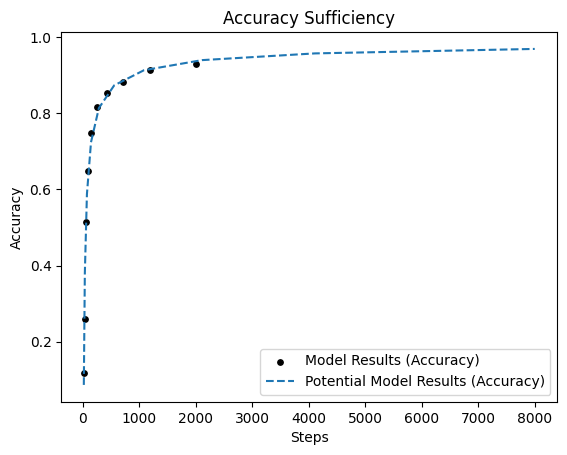

In [14]:
# Plot the output using the convenience function
_ = Sufficiency.plot(output)

In [15]:
# Initialize the array of desired accuracies
desired_accuracies = np.array([0.90, 0.95, 0.99])

# Evaluate the learning curve to infer the needed amount of training data
samples_needed = Sufficiency.inv_project({"Accuracy": desired_accuracies}, output)

In [16]:
# Print the amount of needed data needed to achieve the accuracies of interest
for i, accuracy in enumerate(desired_accuracies):
    print(f"To achieve {int(accuracy*100)}% accuracy, {int(samples_needed['Accuracy'][i])} samples are needed.")

To achieve 90% accuracy, 840 samples are needed.
To achieve 95% accuracy, 2991 samples are needed.
To achieve 99% accuracy, 261727 samples are needed.


In [17]:
# Future BER tie in?

images, labels = [], []
for data in train_ds:
    images.append(np.array(data[0]))
    labels.append(data[1])

images = np.array(images)
labels = np.array(labels)

from dataeval.metrics.estimators import ber

ber_output = ber(images, labels)
np.round(1 - ber_output.ber_lower, 3) * 100

95.7